## Q2: Which product category is the best sellers and which is the worst seller? 

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as scs
from scipy import stats 
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import sqlite3

In [2]:
conn = sqlite3.connect("./Northwind_small.sqlite")
cursor = conn.cursor()

In [3]:
query = '''SELECT  od.OrderID, od.UnitPrice, od.Quantity, od.Discount, ProductName, CategoryName
                            FROM [Order] o
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN Product p ON p.Id = od.ProductId
                            JOIN Category c on c.Id = p.CategoryId;
                            '''
df2 = pd.read_sql(query, conn)

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
OrderId         2155 non-null int64
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
ProductName     2155 non-null object
CategoryName    2155 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 101.1+ KB


,OrderId,UnitPrice,Quantity,Discount,ProductName,CategoryName
0,10248,14.0,12,0.0,Queso Cabrales,Dairy Products
1,10248,9.8,10,0.0,Singaporean Hokkien Fried Mee,Grains/Cereals
2,10248,34.8,5,0.0,Mozzarella di Giovanni,Dairy Products
3,10249,18.6,9,0.0,Tofu,Produce
4,10249,42.4,40,0.0,Manjimup Dried Apples,Produce


In [4]:
# Now let's check out all the column names and see the values counts for each Category Name.

df2.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [5]:
df2['TotalOrderPrice'] = np.multiply(df2['Quantity'],df2['UnitPrice'])
df2['NetPrice'] = np.multiply(df2['TotalOrderPrice'],df2['Discount'])
df2['NetPrice'] = np.subtract(df2['TotalOrderPrice'],df2['NetPrice'])
df2.head()

# I am only looking at TotalOrderPrice, but wan't to add Netprice as well incase I want to see if there is a relationship later on.

,OrderId,UnitPrice,Quantity,Discount,ProductName,CategoryName,TotalOrderPrice,NetPrice
0,10248,14.0,12,0.0,Queso Cabrales,Dairy Products,168.0,168.0
1,10248,9.8,10,0.0,Singaporean Hokkien Fried Mee,Grains/Cereals,98.0,98.0
2,10248,34.8,5,0.0,Mozzarella di Giovanni,Dairy Products,174.0,174.0
3,10249,18.6,9,0.0,Tofu,Produce,167.4,167.4
4,10249,42.4,40,0.0,Manjimup Dried Apples,Produce,1696.0,1696.0


In [6]:
# Now that I added TotalOrderPrice and NetPrice column, I want to group this dataset by Category name.
# The goal is to get an early idea to which product category is the best seller and which is the worst seller.

In [7]:
df2_g = df2.groupby('CategoryName')
df2_g = pd.DataFrame(df2_g.TotalOrderPrice.mean())
df2_g = df2_g.reset_index()

In [8]:
df2_g.columns = ['CategoryName','TotalOrderPrice']
df2_g

,CategoryName,TotalOrderPrice
0,Beverages,709.225124
1,Condiments,526.364583
2,Confections,530.236826
3,Dairy Products,686.695355
4,Grains/Cereals,513.912245
5,Meat/Poultry,1029.993064
6,Produce,774.033824
7,Seafood,429.160879


Text(0.5, 1.0, 'Average Order Price by Product Category')

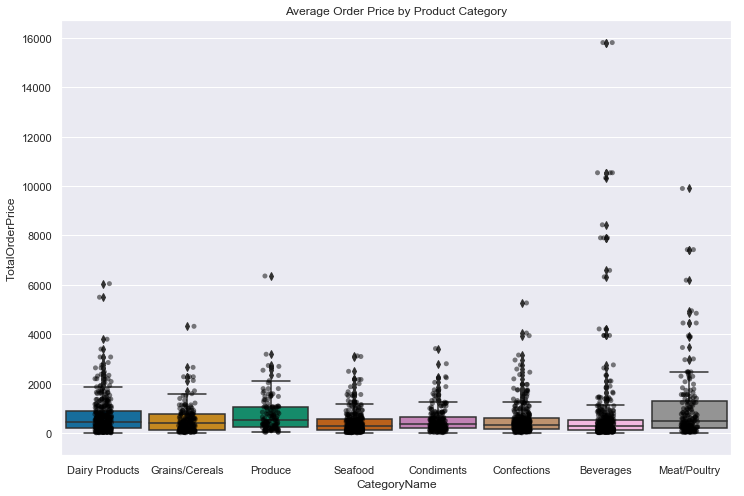

In [9]:
# Now I want to visualize this data by making a boxplot using Seaborn.
sns.set(rc={'figure.figsize':(12,8)})
bplot=sns.boxplot(y='TotalOrderPrice', x='CategoryName', 
                 data=df2, 
                 width=0.9,
                 palette="colorblind")
 
# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='TotalOrderPrice', x='CategoryName', 
                   data=df2, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

plt.title('Average Order Price by Product Category')

# Resource: http://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/

In [10]:
# Looking at this data we can see meat/poultry has the highest total/average order price.

# Hypothesis:

#h0: There is no difference in total order price for Meat/Poultry compared to the other categories.
#ha: There is a difference in total order price for Meat/Poulty.

In [11]:
category_name = list(df2.CategoryName.unique())
category_name

['Dairy Products',
 'Grains/Cereals',
 'Produce',
 'Seafood',
 'Condiments',
 'Confections',
 'Beverages',
 'Meat/Poultry']

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


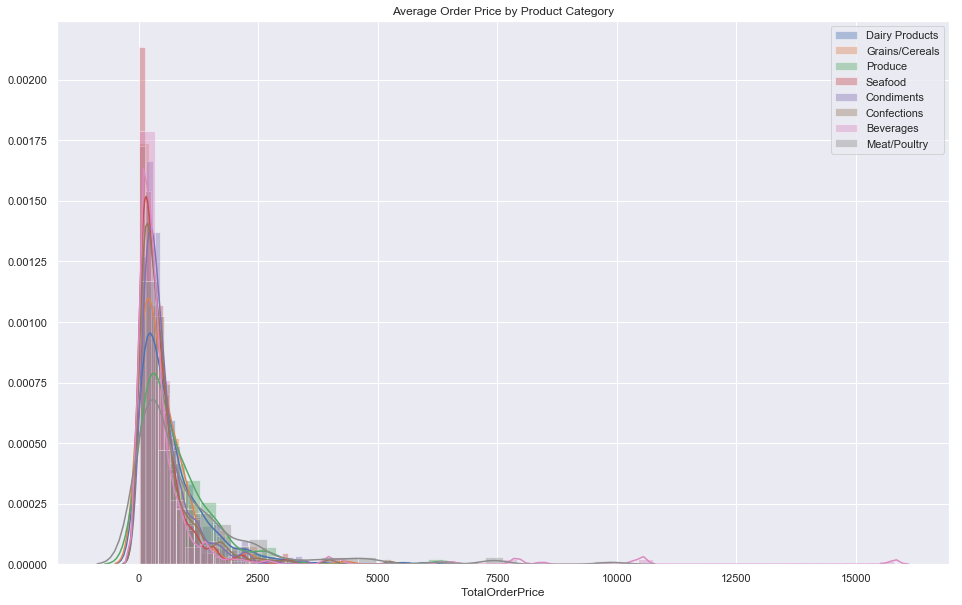

In [12]:
sns.set(rc={'figure.figsize':(16,10)})
for category in category_name:
    sns.distplot(df2.TotalOrderPrice[df2.CategoryName==category], label=category)
plt.title('Average Order Price by Product Category')
plt.legend()

In [13]:
#https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

In [15]:
#Tukey Test
mc = MultiComparison(df2['TotalOrderPrice'], df2['CategoryName'])
result = mc.tukeyhsd(alpha=0.05)

tukey_df2 = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])

tukey_df2

,group1,group2,meandiff,lower,upper,reject
0,Beverages,Condiments,-182.8605,-445.1227,79.4016,False
1,Beverages,Confections,-178.9883,-409.0909,51.1143,False
2,Beverages,Dairy Products,-22.5298,-247.0583,201.9987,False
3,Beverages,Grains/Cereals,-195.3129,-466.1538,75.5280,False
4,Beverages,Meat/Poultry,320.7679,38.0642,603.4717,True
5,Beverages,Produce,64.8087,-243.6479,373.2653,False
6,Beverages,Seafood,-280.0642,-510.9290,-49.1994,True
7,Condiments,Confections,3.8722,-267.7958,275.5403,False
8,Condiments,Dairy Products,160.3308,-106.6324,427.2940,False
9,Condiments,Grains/Cereals,-12.4523,-319.3906,294.4859,False


In [16]:
# I observe the mean difference is very high when meat/poulty is involved ... So I will investigate this.

In [17]:
meat_poultry_tukey2 = tukey_df2[(tukey_df2.group1=='Meat/Poultry')|(tukey_df2.group2=='Meat/Poultry')]
meat_poultry_tukey2

,group1,group2,meandiff,lower,upper,reject
4,Beverages,Meat/Poultry,320.7679,38.0642,603.4717,True
10,Condiments,Meat/Poultry,503.6285,186.1734,821.0835,True
15,Confections,Meat/Poultry,499.7562,208.3056,791.2069,True
19,Dairy Products,Meat/Poultry,343.2977,56.2275,630.3679,True
22,Grains/Cereals,Meat/Poultry,516.0808,191.5025,840.6591,True
25,Meat/Poultry,Produce,-255.9592,-612.5287,100.6102,False
26,Meat/Poultry,Seafood,-600.8322,-892.8849,-308.7794,True


In [18]:
# Now I want to observe effect size for meat/poulty with respect to the other product groups.

In [19]:
def cohens_d(df1, df2):
    """Calculates the effect size for Cohen's 'd' test given two samples.
    """
    mean_diff = np.mean(df1) - np.mean(df2)
    n1, n2 = len(df1)-1, len(df2)-1
    var1, var2 = np.var(df1,ddof=1), np.var(df2,ddof=1)
    
    pooled_var = (n1*var1 + n2*var2)/(n1 + n2)
    
    d = mean_diff/(pooled_var**0.5)
    
    return abs(d)

In [20]:
meat_poultry = df2.TotalOrderPrice[df2.CategoryName=='Meat/Poultry']
category_names = ['Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Produce','Seafood']

In [21]:
effect_sizes = []
print('Effect Size for Meat/Poultry')
for category in category_names:
    d = cohens_d(meat_poultry,df2.TotalOrderPrice[df2.CategoryName==category])
    print(f"{category}: d= {d}")
    effect_sizes.append(round(d,3))

Effect Size for Meat/Poultry
Beverages: d= 0.1898645587420658
Condiments: d= 0.4859560835833852
Confections: d= 0.504525735160746
Dairy Products: d= 0.33519853691986795
Grains/Cereals: d= 0.4842860709692641
Produce: d= 0.21190504145147088
Seafood: d= 0.6490208980224711


In [23]:
meat_poultry_tukey2['Effect Size'] = effect_sizes
meat_poultry_tukey2

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,group1,group2,meandiff,lower,upper,reject,Effect Size
4,Beverages,Meat/Poultry,320.7679,38.0642,603.4717,True,0.190
10,Condiments,Meat/Poultry,503.6285,186.1734,821.0835,True,0.486
15,Confections,Meat/Poultry,499.7562,208.3056,791.2069,True,0.505
19,Dairy Products,Meat/Poultry,343.2977,56.2275,630.3679,True,0.335
22,Grains/Cereals,Meat/Poultry,516.0808,191.5025,840.6591,True,0.484
25,Meat/Poultry,Produce,-255.9592,-612.5287,100.6102,False,0.212
26,Meat/Poultry,Seafood,-600.8322,-892.8849,-308.7794,True,0.649


In [25]:
# Bigger Effect size - better it is --> Meat/Poultry and Seafood

In [2]:
# Conclusion - We reject the null hypothesis that there is no difference in total order price for Meat/Poulty compared to other categories.